In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

#To manage whether there is a google drive connected or not
drive_mounted = False


In [4]:
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    drive_mounted = True
except:
    drive_mounted = False



Mounted at /content/drive


In [5]:
# using Chars74k dataset

import tarfile

!wget -O EnglishFnt.tgz http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
tar = tarfile.open('EnglishFnt.tgz')

--2024-10-28 18:08:59--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://info-ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz [following]
--2024-10-28 18:08:59--  https://info-ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
Resolving info-ee.surrey.ac.uk (info-ee.surrey.ac.uk)... 51.132.210.128
Connecting to info-ee.surrey.ac.uk (info-ee.surrey.ac.uk)|51.132.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Cookie coming from info-ee.surrey.ac.uk attempted to set domain to rp-web-iee-01.azurewebsites.net
Cookie coming from info-ee.surrey.ac.uk attempted to set domain to rp-web-iee-01.azurewebsites.net
Length: 49817950 (48M) [application/octet-stream]
Saving to: ‘EnglishFnt.tgz’

EnglishFnt.tgz      100%[===

In [6]:
tar.extractall('./EnglishFnt')

In [7]:
tar.close()

  Image Augmentation and loading

In [9]:
# transforms on datasets


data = torchvision.datasets.ImageFolder(
    root='./EnglishFnt/English/Fnt',
    transform=transforms.Compose([
        transforms.Resize((48,48)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])
)


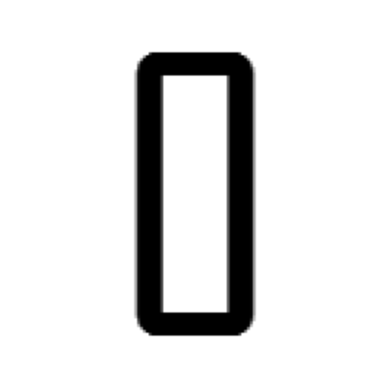

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = '/content/EnglishFnt/English/Fnt/Sample001/img001-00001.png'

image_1 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image_1, cmap = 'gray')
plt.axis('off')
plt.show()

# resize image
resize_image_1 = cv2.resize(image_1, (48,48))



# normalize image

normalized_image1 = (resize_image_1 / 255.0 - 0.5 ) / 0.5



# convert image to tensor (N, C, H , W)
input_tensor = np.expand_dims(normalized_image1, axis=(0, 1))  # Add batch and channel dimensions


In [12]:
print(input_tensor.shape)

(1, 1, 48, 48)


In [19]:
from torch.utils.data import random_split, DataLoader

generator1 = torch.Generator().manual_seed(42)

test_split = 0.3


test_size = int(test_split * len(data))
train_size = len(data) - test_size




train_dataset, test_dataset = random_split(data, [train_size, test_size], generator=generator1)

# val
val_size = int(0.5 * len(test_dataset))
test_size = len(test_dataset) - val_size


val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size], generator=generator1)


# Dataloader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle= True)


In [21]:
# Train dataset

for batch in train_loader:
  images, labels = batch
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 48, 48])
torch.Size([32])


In [22]:
class OCRNet(nn.Module):
  def __init__(self, num_features):

    super(OCRNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1)
    self.fc = nn.Linear(num_features, 62)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x= F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x


num_features = 32 * 48 * 48
model = OCRNet(num_features)



In [23]:
# optimizer

optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
criterion = nn.CrossEntropyLoss()



In [28]:
# Training

def train(model, train_loader, optimizer, criterion, num_epochs, print_every = 100):

  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    running_count = 0
    for i, (images, labels) in enumerate (train_loader):
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      running_count += 1



      # Print average loss every 'print_every' mini-batches
      if (i+1) % print_every == 0:

          print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss: {running_loss/running_count:.4f}")
          running_loss = 0.0
          running_count = 0

  # Print loss after each epoch
  epoch_loss = running_loss / len(train_loader)
  print(f"\nEnd of Epoch {epoch+1}/{num_epochs}, Average Epoch Loss: {epoch_loss:.4f}")



In [30]:
train(model, train_loader, optimizer, criterion, num_epochs=20)

Epoch [1/20], Step [100/1378], Average Loss: 0.0731
Epoch [1/20], Step [200/1378], Average Loss: 0.0739
Epoch [1/20], Step [300/1378], Average Loss: 0.0606
Epoch [1/20], Step [400/1378], Average Loss: 0.0771
Epoch [1/20], Step [500/1378], Average Loss: 0.0897
Epoch [1/20], Step [600/1378], Average Loss: 0.0797
Epoch [1/20], Step [700/1378], Average Loss: 0.0727
Epoch [1/20], Step [800/1378], Average Loss: 0.0850
Epoch [1/20], Step [900/1378], Average Loss: 0.0981
Epoch [1/20], Step [1000/1378], Average Loss: 0.0970
Epoch [1/20], Step [1100/1378], Average Loss: 0.0817
Epoch [1/20], Step [1200/1378], Average Loss: 0.0918
Epoch [1/20], Step [1300/1378], Average Loss: 0.0895
Epoch [2/20], Step [100/1378], Average Loss: 0.0749
Epoch [2/20], Step [200/1378], Average Loss: 0.0794
Epoch [2/20], Step [300/1378], Average Loss: 0.0824
Epoch [2/20], Step [400/1378], Average Loss: 0.0844
Epoch [2/20], Step [500/1378], Average Loss: 0.0768
Epoch [2/20], Step [600/1378], Average Loss: 0.0917
Epoch [2

In [44]:
def validation(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  avg_loss = running_loss / len(val_loader)
  accuray = 100 * correct / total
  print(f"Validation loss : {avg_loss: .4f}, Validation accruay: {accuray: .2f}%")


In [46]:
def test(model, test_loader, criterion):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  avg_loss = running_loss / len(test_loader)
  accuray = 100 * correct / total
  print(f"Test loss : {avg_loss: .4f}, Test accruay: {accuray: .2f}%")

In [ ]:
validation(model, val_loader, criterion)

In [ ]:
test(model, test_loader, criterion)

In [49]:
# save model
torch.save(model.state_dict(), '/content/PyTorch_OCR.pth')

# load model

model = OCRNet(num_features)

model.load_state_dict(torch.load('/content/PyTorch_OCR.pth'))


# eval
model.eval()


<ipython-input-49-cdbc37d91fa4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/PyTorch_OCR.pth'))


OCRNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=73728, out_features=62, bias=True)
)

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation
preprocess = transforms.Compose([
    transforms.ToPILImage(),              # Convert from OpenCV (NumPy) to PIL format
    transforms.Resize((48, 48)),          # Resize the image to 48x48
    transforms.ToTensor(),                # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# Define the classes
classes = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')

def predict(model, image):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Forward pass
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)

        predicted_class = classes[predicted_idx.item()]
        confidence = predicted_prob.item() * 100  # Convert to percentage

        print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')

        return predicted_class, confidence

image_path = '/content/EnglishFnt/English/Fnt/Sample062/img062-00030.png'

image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load the image in BGR format

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = preprocess(image).unsqueeze(0)  # Add batch dimension

predicted_class, confidence = predict(model, image)

# Display the image with prediction
image_display = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the original image
image_display = cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
plt.imshow(image_display)
plt.title(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')
plt.axis('off')
plt.show()
